<a href="https://colab.research.google.com/github/orengerc/wien-filter/blob/main/notebooks_Wein_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wein Filter

## Part 1 - Calculating trajectory of a particle under constant magnetic & electric fields;

#### Import the desired libraries:

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage as nd
from enum import IntEnum

#### Define the proper variables and initial conditions:

In [42]:
class Coordinate(IntEnum):
    """
    Defines the coordinates used in the excercise.
    """
    X = 0
    Y = 1
    Z = 2


# Constants of the problem
E = 5
B = 1
q = 1
m = 1

# initialize the variables
omega = q * B / m
T = 2 * np.pi / omega
DELTA_T = 0.01
N = int(T / DELTA_T)

r, v = np.zeros((N, 3)), np.zeros((N, 3))
v[0][2] = 3 * E / B

#### Funtions that calculate the position and velocity of the particle:

In [43]:
def update_position(r, v, i, method):
    """
    Updates position vector of the charged particle.
    :param i: iteration we are on
    :return: nothing
    """

    if method == 'TAYLOR':
        r[i, :] = r[i - 1, :] + v[i - 1, :] * DELTA_T
    elif method == 'MIDPOINT':
        # calculate v at half dt

        accelerations = calculate_accelerations(v[i - 1, :])
        k1 = accelerations * DELTA_T

        v_half = v[i - 1, :] + 0.5 * k1

        k2 = DELTA_T * v_half

        # v_n+1 = v_n + k2
        r[i, :] = r[i - 1, :] + k2
    elif method == 'RUNGE-KUTTA':
        # accelerations = calculate_accelerations(v[i - 1, :])
        # k1 = accelerations * DELTA_T
        #
        # v_half = v[i - 1, :] + 0.5 * k1
        # k2 = DELTA_T * v_half
        #
        # # all good
        # accelerations = calculate_accelerations(v_half)
        # v_3 =
        # k3 = accelerations * DELTA_T
        # v_3 = v_half + 0.5 * k3
        #
        # r_4 = r[i - 1, :] + DELTA_T * v_3
        #
        # # ddd
        #
        # r_half = r[i - 1, :] + k2 * 0.5
        # v_half = calculate_velocity(r_half)
        # k3 = DELTA_T * v_half
        #
        # r_half = r[i - 1, :] + k3 * 0.5
        # v_half = calculate_accelerations(r_half)
        # k4 = DELTA_T * v_half
        #
        # v[i, :] = v[i - 1, :] + float(1 / 6) * (k1 + (2 * k2) + (2 * k3) + k4)

        accelerations = calculate_accelerations(v[i - 1, :])
        k1 = accelerations * DELTA_T

        v_half = v[i - 1, :] + 0.5 * k1

        k2 = DELTA_T * v_half

        # v_n+1 = v_n + k2
        r[i, :] = r[i - 1, :] + k2
    return r, v


def calculate_accelerations(velocities):
    factor = q / m
    return np.array(
        [0, factor * (E - B * velocities[Coordinate.Z]),
         factor * B * velocities[Coordinate.Y]])


def update_velocity(r, v, i, method):
    """
    Updates velocity vector of the charged particle.
    :param i: iteration we are on
    :return: nothing
    """

    accelerations = calculate_accelerations(v[i - 1, :])
    if method == 'TAYLOR':
        v[i, :] = v[i - 1, :] + accelerations * DELTA_T
    elif method == 'MIDPOINT':
        k1 = DELTA_T * accelerations

        v_half = v[i - 1, :] + k1 * 0.5
        a_half = calculate_accelerations(v_half)

        k2 = DELTA_T * a_half

        # v_n+1 = v_n + k2
        v[i, :] = v[i - 1, :] + k2

    elif method == 'RUNGE-KUTTA':
        k1 = DELTA_T * accelerations

        v_half = v[i - 1, :] + k1 * 0.5
        a_half = calculate_accelerations(v_half)
        k2 = DELTA_T * a_half

        v_half = v[i - 1, :] + k2 * 0.5
        a_half = calculate_accelerations(v_half)
        k3 = DELTA_T * a_half

        v_half = v[i - 1, :] + k3
        a_half = calculate_accelerations(v_half)
        k4 = DELTA_T * a_half

        v[i, :] = v[i - 1, :] + float(1 / 6) * (k1 + (2 * k2) + (2 * k3) + k4)

    return r, v


def calculate(r, v, method):
    """
    Iterates until end of T, each iteration calculating the current positions and velocities.
    :return: nothing
    """
    for i in range(N - 1):
        r, v = update_velocity(r, v, i + 1, method)
        r, v = update_position(r, v, i + 1, method)
    return r, v


def graph_motion(r, v, method):
    """
    Plots position and velocity of particle in the Y axis vs. Z axis
    :return: nothing
    """

    # graph position of particle in Z,Y plane
    plt.plot(r[:, Coordinate.Y], r[:, Coordinate.Z])
    plt.xlabel("Y [Arbitrary Units]")
    plt.ylabel("Z [Arbitrary Units]")
    plt.title("{}: Position of particle in Z,Y plane".format(method))
    plt.grid()
    plt.show()

    # graph position of particle in 3D
    ax = plt.axes(projection='3d')
    ax.scatter3D(r[:, Coordinate.X], r[:, Coordinate.Y], r[:, Coordinate.Z], c=r[:, Coordinate.Z], cmap='Greens')
    plt.title(f"{method}: Position of particle in 3D")
    plt.show()

    # graph position of particle in Z,Y plane
    plt.plot(v[:, Coordinate.Y], v[:, Coordinate.Z])
    plt.xlabel("Velocity in Y direction [Arbitrary Units]")
    plt.ylabel("Velocity in Z direction [Arbitrary Units]")
    plt.title(f"{method}: Velocity of particle in Z,Y plane")
    plt.grid()
    plt.show()

def graph_error(r, v):
    pass


def run(r, v, method, plot_motion=False):
    """
    Calculates the positions and velocities at any time using the desired method,
    then graphs the positions and velocities and their accumulated error.
    :return:
    """
    calculate(r, v, method)
    if(plot_motion):
      graph_motion(r, v, method)


def simple_graph(x, y, x_title, y_title, title):
    plt.plot(x, y)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.grid()
    plt.show()


def analytical_solution():
    w = q * B / m
    return np.array([0,
                     2 * E * m / (q * np.square(B)) * (np.cos(w * T) - 1),
                     (E / B) * (2 * m / (q * B) * np.sin(w * T) + T)])


#### Plot trajectory of the particle:

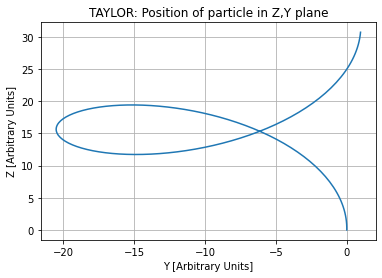

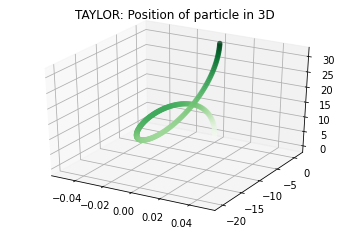

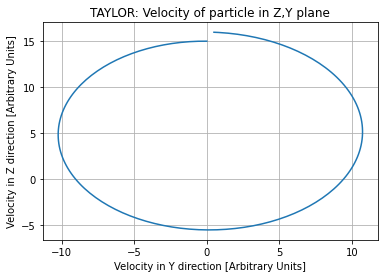

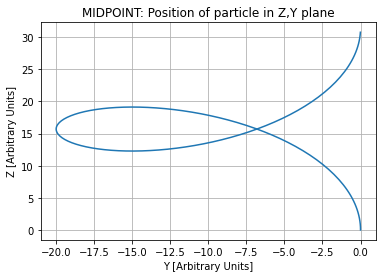

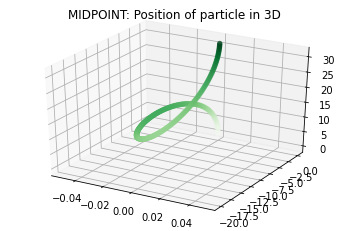

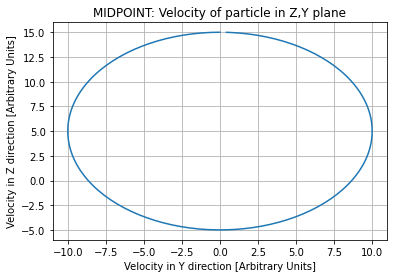

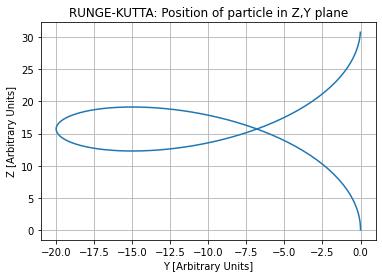

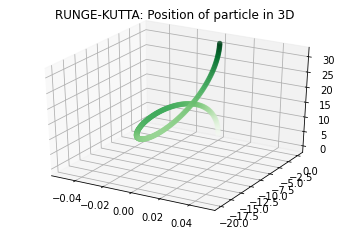

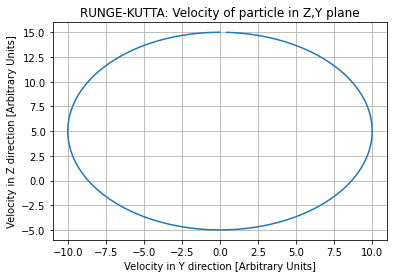

In [44]:
for method in [
    "TAYLOR",
    "MIDPOINT",
    "RUNGE-KUTTA"
]:
    DELTA_T = 0.03
    N = int(T / DELTA_T)

    r, v = np.zeros((N, 3)), np.zeros((N, 3))
    v[0][Coordinate.Z] = 3 * E / B
    run(r, v, method, plot_motion = True)

#### Graph errors for different time-intervals (dt):

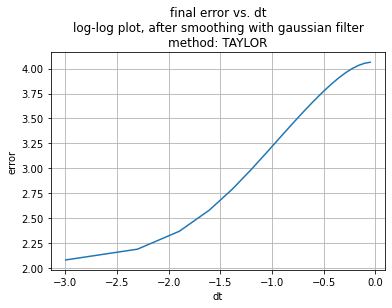

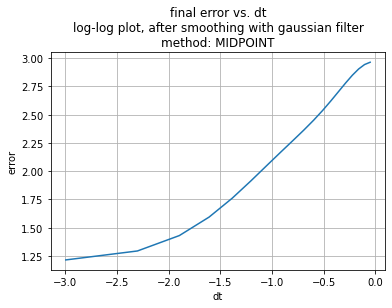

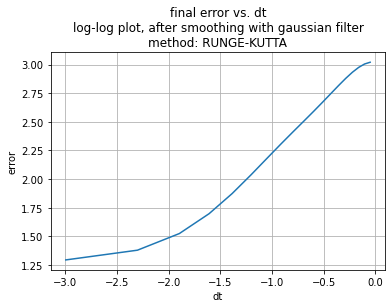

In [45]:
for method in [
    "TAYLOR",
    "MIDPOINT",
    "RUNGE-KUTTA"
]:
    errors = []
    dts = np.arange(0.05, 1, 0.05, dtype=np.float64)
    for dt in dts:
        DELTA_T = dt
        N = int(T / DELTA_T)

        r, v = np.zeros((N, 3)), np.zeros((N, 3))
        v[0][Coordinate.Z] = 3 * E / B
        run(r, v, method)

        last_pos = r[-1]
        errors.append(np.linalg.norm(last_pos - analytical_solution()))

    # simple_graph(dts, errors, "dt", "error", f"final error vs. dt\nregular plot\nmethod: {method}")
    # simple_graph(np.log(dts), np.log(errors), "dt", "error", f"final error vs. dt:\nlog-log plot\nmethod: {method}")
    simple_graph(np.log(dts), np.log(nd.gaussian_filter1d(errors, 3)), "dt", "error",
                 f"final error vs. dt\nlog-log plot, after smoothing with gaussian filter\nmethod: {method}")
